# Predicting location of hyperbolas Object Detection

This Notebook is based on the interaction with the YOLO Model for Object Detection. And how to try to fit hyperbolas

- Chapter 1: Load Yolo Model
- Chapter 2: Predicting Locations of Hyperbolas with YOLO Model
- Chapter 3: Extracting Bounding Boxes
- Chapter 4: Implementation in Pipeline
- Chapter 5: fitting Hyperbolas out of detections



### Chapter 1: Load Yolo Model

following code shows loading a Yolo Model directly threw the **ultralytics** Library.

In [1]:
#import libraries
import numpy as np
from ultralytics import YOLO

#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *




In [2]:
#Load trained Model for Object Detection
model = YOLO(YOLO_MODEL_OD_DIR)


### Chapter 2: Predicting Locations of Hyperbolas with YOLO Model

for prediction Data is needed. The idea is to take a sgy file and use the same code as when created the images for training but now it is used to create random test pictures out of the file. Second Option is that we take the test set out of Roboflow. for the first option a function is created.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import segyio
import random

def create_random_test_images(df, file, test_inline_random:bool = False, test_crossline_random:bool = False, test_timeslice_random:bool = False,
                        number_random_inlines:int = 1, number_random_crosslines:int = 1, number_random_timeslices:int = 1
                        ):
    
    outdir = TEST_PIC_DIR
    filename = df["filename"].iloc[0]

    bin_header = dict(file.bin)
    bin_header_dict = dict(bin_header)
    n_samples = int(bin_header_dict[segyio.BinField.Samples])

    inlines = sorted(df["inline"].unique())
    crosslines = sorted(df["crossline"].unique())

    il_map = {v: i for i, v in enumerate(inlines)}
    cl_map = {v: i for i, v in enumerate(crosslines)}

    if test_inline_random:
        inlines = random.sample(inlines, min(number_random_inlines, len(inlines)))
        for inline_nr in inlines:
            sub = df[df["inline"] == inline_nr].sort_values("crossline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_inline_{inline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(inlines)} images to {outdir}")
        
    if test_crossline_random:
        crosslines = random.sample(crosslines, min(number_random_crosslines, len(crosslines)))
        for crossline_nr in crosslines:
            sub = df[df["crossline"] == crossline_nr].sort_values("inline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_crossline_{crossline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(crosslines)} images to {outdir}")
        
    if test_timeslice_random:
        rand_timeslices = random.sample(range(n_samples), min(number_random_timeslices, n_samples))
        for sample_index in rand_timeslices:
            mat = np.full((len(inlines), len(crosslines)), np.nan)

            for _,row in df.iterrows():
                i = il_map[row["inline"]]
                j = cl_map[row["crossline"]]
                mat[i, j] = row["Amplitude"][sample_index]
        
            img = np.nan_to_num(mat)
            out_path=os.path.join(outdir, f"{filename}_timeslice_{sample_index}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(rand_timeslices)} images to {outdir}")






next step is to load the File

In [4]:
from Pipeline.Datatoolkit import DatatoolKit

dk = DatatoolKit(TEST_FILE_DIR , "EG-3D QUER001.SGY")
file = dk.LoadSGY()
df = dk.create_df(file)

lets create random test pictures

In [5]:
create_random_test_images(df=df, 
              file=file,
              test_inline_random=True,
              number_random_inlines=3)

saved 3 images to c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_22.png


Next step is to make prediction of images which are in one directory.

In [7]:
model.predict(TEST_PIC_DIR,save =True, conf=0.1)


image 1/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_15.png: 128x640 1 hyperbola, 88.1ms
image 2/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_17.png: 128x640 1 hyperbola, 36.0ms
image 3/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\EG-3D QUER001.SGY_inline_47.png: 128x640 1 hyperbola, 33.4ms
image 4/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_52.png: 384x640 16 hyperbolas, 109.6ms
image 5/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_58.png: 384x640 19 hyperbolas, 74.1ms
image 6/6 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_59.png: 384x640 17 hyperbolas, 68.5ms
Speed: 2.2ms preprocess, 68.3ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\pythonad\PAINDHS25\PAINDGPR\Notebooks\runs\segment\predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'hyperbola'}
 obb: None
 orig_img: array([[[101, 101, 101],
         [101, 101, 101],
         [101, 101, 101],
         ...,
         [ 99,  99,  99],
         [ 96,  96,  96],
         [ 94,  94,  94]],
 
        [[ 87,  87,  87],
         [ 88,  88,  88],
         [ 88,  88,  88],
         ...,
         [ 92,  92,  92],
         [ 89,  89,  89],
         [ 88,  88,  88]],
 
        [[ 85,  85,  85],
         [ 85,  85,  85],
         [ 86,  86,  86],
         ...,
         [ 84,  84,  84],
         [ 85,  85,  85],
         [ 84,  84,  84]],
 
        ...,
 
        [[136, 136, 136],
         [105, 105, 105],
         [109, 109, 109],
         ...,
         [125, 125, 125],
         [ 97,  97,  97],
         [141, 141, 141]],
 
        [[149, 149, 149],
         [119, 119, 119],
         [128, 128, 

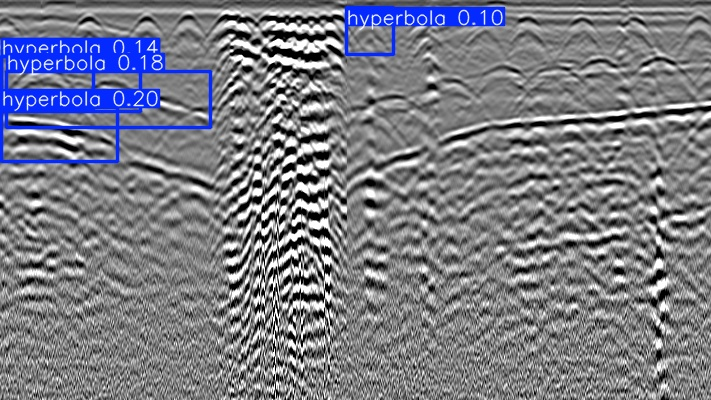

It shows that with the Object Detection Model there are not much hyperbolas are detected even with a low confidence setting.

## Chapter 3: Extracting Bounding Boxes

for further processing the Bounding boxes of predictions are needed. With Yolo it is fairyl simple to extract those bounding boxes. For that a function is implemented that does exactly that. The idea is that it extracts all bounding bounding boxes from all images predictions are made on. This function makes predictions and extracting bounding boxes simultaniously

In [6]:
def extract_bboxes(prediction_folder)-> list:
    results = model.predict(source=prediction_folder, save = True, conf=0.1)
    all_boxes = {}

    for result in results:
        img_name = os.path.basename(result.path)
        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
            all_boxes[img_name] = boxes# Bounding boxes in (x1, y1, x2, y2) format
        else:
            all_boxes[img_name] = np.empty((0,4))       
        
    return all_boxes

In [7]:
boxes = extract_bboxes(TEST_PIC_DIR)


image 1/2 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_18.png: 384x640 5 hyperbolas, 103.8ms
image 2/2 c:\vscode\PAINDGPR\Data\Testdata\pictures\frame_0.jpg: 448x640 5 hyperbolas, 75.7ms
Speed: 2.4ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to C:\vscode\PAINDGPR\Notebooks\runs\detect\predict


In [37]:
print(boxes)

{'UG3DQUERUNTERZUG.SGY_inline_52.png': array([[      1.137,      107.46,      117.34,      161.32],
       [     6.4071,      71.518,      210.26,      127.78],
       [     1.1274,      56.227,       93.03,      110.63],
       [      1.466,      56.229,      140.63,      111.66],
       [     346.46,      7.3693,      393.12,      54.333]], dtype=float32), 'UG3DQUERUNTERZUG.SGY_inline_59.png': array([[    0.16984,      11.065,      32.777,      55.192],
       [     508.71,      5.6568,       557.3,      50.618],
       [     561.52,      8.3862,      609.23,      50.604],
       [     1.4096,      104.31,      148.92,      164.06],
       [     1.8562,      56.717,      162.21,      106.66],
       [     612.34,      9.4982,      664.65,      50.352],
       [     675.03,      5.3894,         711,      53.813],
       [     62.903,      8.4614,      111.32,       56.05],
       [     401.13,      53.629,      650.72,      107.15]], dtype=float32), 'frame_0.jpg': array([[     151.06,

## Chapter 4: Implementation in Pipeline

Out of the knowledge gained in the above Chapters a **Predictor** class is implemented in the pipeline. Which is used to interact with the Yolo model results. The function **extract_boxes()**  is divided in to two main functions one for making predictions with YOLO and returning the result and one for extracting the bounding boxes out of the result. the methods implemented are following: \
- **predict_location_hyperbolas()**
- **extract_boxes()**